In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, start=0, end=None):
  plt.plot(time[start:end], series[start:end], "-")
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[:-1]))
  ds = ds.batch(batch_size).prefetch(1)
  return ds

In [6]:
tf.random.set_seed(42)
np.random.seed(42)

tf.keras.backend.clear_session()

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum = 0.9)
model.compile(loss="mse", optimizer=optimizer, metrics="mae")
history = model.fit(dataset, epochs=200)

Epoch 1/200
31/31 [==============================] - 1s 33ms/step - loss: 1328.3484 - mae: 27.1221
Epoch 2/200
31/31 [==============================] - 1s 31ms/step - loss: 137.9436 - mae: 9.0822
Epoch 3/200
31/31 [==============================] - 1s 32ms/step - loss: 57.7735 - mae: 5.2785
Epoch 4/200
31/31 [==============================] - 1s 31ms/step - loss: 47.9306 - mae: 4.5926
Epoch 5/200
31/31 [==============================] - 1s 32ms/step - loss: 51.7287 - mae: 4.9627
Epoch 6/200
31/31 [==============================] - 1s 31ms/step - loss: 47.6218 - mae: 4.6375
Epoch 7/200
31/31 [==============================] - 1s 32ms/step - loss: 48.2222 - mae: 4.6878
Epoch 8/200
31/31 [==============================] - 1s 32ms/step - loss: 45.9732 - mae: 4.4743
Epoch 9/200
31/31 [==============================] - 1s 31ms/step - loss: 43.6662 - mae: 4.2730
Epoch 10/200
31/31 [==============================] - 1s 31ms/step - loss: 47.8712 - mae: 4.7048
Epoch 11/200
31/31 [===============

4.887398


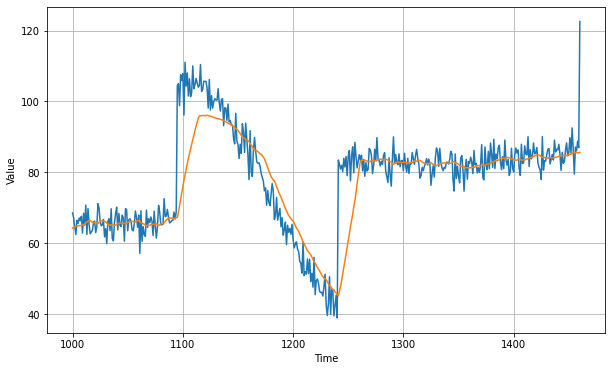

In [7]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

<Figure size 432x288 with 0 Axes>

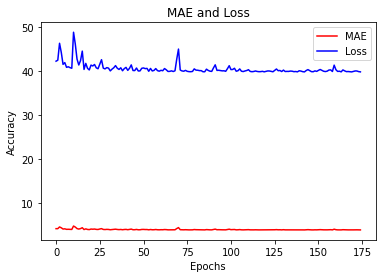

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae'][25:]
loss=history.history['loss'][25:]

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()